[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gsarti/ik-nlp-tutorials/blob/main/notebooks/W6T_Advanced_Prompting_Generation.ipynb)

In [1]:
# Run in Notebook to install local packages
!pip install torch transformers bitsandbytes accelerate rank_bm25 outlines datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

checkpoint = "Qwen/Qwen2.5-1.5B-Instruct"

# Configure 8-bit quantization. We use this to save VRAM, as we don't have a lot available.
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True  # Enables 8-bit quantization
)

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForCausalLM.from_pretrained(
    checkpoint,
    quantization_config=bnb_config,  # Apply BitsAndBytesConfig
    device_map="cuda"   # Assign to GPU
)






/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

In [ ]:
# Load in Sciq dataset
import pandas as pd

splits = {'train': 'data/train-00000-of-00001.parquet', 'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df_train = pd.read_parquet("hf://datasets/allenai/sciq/" + splits["train"])
df_val = pd.read_parquet("hf://datasets/allenai/sciq/" + splits["validation"])

# Merge all datasets into one
df_all = pd.concat([df_train, df_val], ignore_index=True)


In [ ]:
# Divide the contexts into small, medium, long
small_df = pd.DataFrame(columns=df_all.columns)
medium_df = pd.DataFrame(columns=df_all.columns)
long_df = pd.DataFrame(columns=df_all.columns)

small = 0
medium = 0
longg = 0

for idx, row in df_all.iterrows():
  if len(row["support"]) < 100:
    if small < 1000:
      small_df.loc[idx] = row
    small += 1
  elif 100 < len(row["support"]) < 500:
    if medium < 1000:
      medium_df.loc[idx] = row
    medium += 1
  else:
    if longg < 1000:
      long_df.loc[idx] = row
    longg += 1


In [ ]:
experiments = ["long", "long_a", "medium","medium_a", "small", "small_a"]
original_context = "You are a QA system that only answers with a singular letter as an answer"

for experiment in experiments:
  if experiment == "long":
    used_df = long_df
  elif experiment == "long_a":
    used_df = long_df
  elif experiment == "medium":
    used_df = medium_df
  elif experiment == "medium_a":
    used_df = medium_df
  elif experiment == "small":
    used_df = small_df
  elif experiment == "small_a":
    used_df = small_df

  for idx, row in used_df.iterrows():
    if "_A" in experiment:
      to_ask = (
      row["question"] +
      " A " + row["correct_answer"] +
      ", B " + row["distractor2"] +
      ", C " + row["distractor1"] +
      ", D " + row["distractor3"]
      )
    else:
      to_ask = (
        row["question"] +
        " A " + row["distractor3"] +
        ", B " + row["distractor2"] +
        ", C " + row["distractor1"] +
        ", D " + row["correct_answer"]
      )

    context = (
          original_context +
          row["support"]
      )


    messages = [
      {
          "role": "system",
          "content": context,
      },
      {"role": "user", "content": to_ask},
      ]
    tokenized_chat = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")
    outputs = model.generate(tokenized_chat, max_new_tokens=128)
    answer = tokenizer.decode(outputs[0]).splitlines()[-1][0]
    used_df.loc[idx, experiment] = answer


    print(experiment, idx)

  print(used_df.shape)
  df = pd.DataFrame(used_df)
  df.to_csv("additional_med_" + experiment + ".csv")

In [ ]:
experiments = ["harder_context_2", "harder_context_A_2", "harder_context_20", "harder_context_20_A"]
original_context = "You are a QA system that only answers with a singular letter as an answer"
harder_context_2 = pd.read_csv("harder_context.csv")[:2]
harder_context_20 = pd.read_csv("harder_context.csv")[:20]
tf = []

for experiment in experiments:
  for idx, row in df_all.iterrows():
    if "_A" in experiment:
      to_ask = (
      row["question"] +
      " A " + row["correct_answer"] +
      ", B " + row["distractor2"] +
      ", C " + row["distractor1"] +
      ", D " + row["distractor3"]
      )
    else:
      to_ask = (
        row["question"] +
        " A " + row["distractor3"] +
        ", B " + row["distractor2"] +
        ", C " + row["distractor1"] +
        ", D " + row["correct_answer"]
      )

    if experiment == "harder_context_2" or experiment == "harder_context_A_2":
      context = (
            original_context +
            row["support"] +
            "".join([str(support) for support in harder_context_2["support"].tolist()])
      )

    else:
      context = (
            original_context +
            row["support"] +
            "".join([str(support) for support in harder_context_20["support"].tolist()])
      )


    messages = [
      {
          "role": "system",
          "content": context,
      },
      {"role": "user", "content": to_ask},
      ]


    tokenized_chat = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")
    outputs = model.generate(tokenized_chat, max_new_tokens=128)

    decoded_output = tokenizer.decode(outputs[0])
    output_lines = decoded_output.splitlines()

    if output_lines and output_lines[-1]:
        answer = output_lines[-1][0]
        df_all.loc[idx, experiment] = answer
    else:
        df_all.loc[idx, experiment] = ""
        tf.append(output_lines[-1])
    print(experiment, idx)

In [ ]:
df = pd.DataFrame(df_all)
df.to_csv("additional_med_harder.csv")

In [ ]:
checkpoint = "Qwen/Qwen2-0.5b-instruct"

# Configure 8-bit quantization. We use this to save VRAM, as we don't have a lot available.
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True  # Enables 8-bit quantization
)

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForCausalLM.from_pretrained(
    checkpoint,
    quantization_config=bnb_config,  # Apply BitsAndBytesConfig
    device_map="cuda"   # Assign to GPU
)

In [ ]:
experiments = ["long", "long_a", "medium","medium_a", "small", "small_a"]
original_context = "You are a QA system that only answers with a singular letter as an answer"

for experiment in experiments:
  if experiment == "long":
    used_df = long_df
  elif experiment == "long_a":
    used_df = long_df
  elif experiment == "medium":
    used_df = medium_df
  elif experiment == "medium_a":
    used_df = medium_df
  elif experiment == "small":
    used_df = small_df
  elif experiment == "small_a":
    used_df = small_df

  for idx, row in used_df.iterrows():
    if "_A" in experiment:
      to_ask = (
      row["question"] +
      " A " + row["correct_answer"] +
      ", B " + row["distractor2"] +
      ", C " + row["distractor1"] +
      ", D " + row["distractor3"]
      )

    else:
      to_ask = (
        row["question"] +
        " A " + row["distractor3"] +
        ", B " + row["distractor2"] +
        ", C " + row["distractor1"] +
        ", D " + row["correct_answer"]
      )

    context = (
          original_context +
          row["support"]
      )


    messages = [
      {
          "role": "system",
          "content": context,
      },
      {"role": "user", "content": to_ask},
      ]
    tokenized_chat = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")
    outputs = model.generate(tokenized_chat, max_new_tokens=128)
    answer = tokenizer.decode(outputs[0]).splitlines()[-1][0]
    used_df.loc[idx, experiment] = answer
    print(experiment, idx)

  print(used_df.shape)
  df = pd.DataFrame(used_df)
  df.to_csv("additional_small_" + experiment + ".csv")


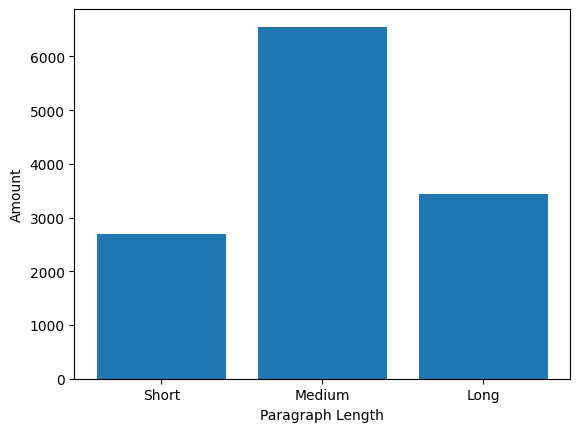

In [22]:
experiments = ["harder_context_2", "harder_context_A_2", "harder_context_20", "harder_context_20_A"]
original_context = "You are a QA system that only answers with a singular letter as an answer"
harder_context_2 = pd.read_csv("harder_context.csv")[:2]
harder_context_20 = pd.read_csv("harder_context.csv")[:20]
tf = []

for experiment in experiments:
  for idx, row in df_all.iterrows():
    if "_A" in experiment:
      to_ask = (
      row["question"] +
      " A " + row["correct_answer"] +
      ", B " + row["distractor2"] +
      ", C " + row["distractor1"] +
      ", D " + row["distractor3"]
      )
    else:
      to_ask = (
        row["question"] +
        " A " + row["distractor3"] +
        ", B " + row["distractor2"] +
        ", C " + row["distractor1"] +
        ", D " + row["correct_answer"]
      )

    if experiment == "harder_context_2" or experiment == "harder_context_A_2":
      context = (
            original_context +
            row["support"] +
            "".join([str(support) for support in harder_context_2["support"].tolist()])
      )

    else:
      context = (
            original_context +
            row["support"] +
            "".join([str(support) for support in harder_context_20["support"].tolist()])
      )


    messages = [
      {
          "role": "system",
          "content": context,
      },
      {"role": "user", "content": to_ask},
      ]


    tokenized_chat = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")
    outputs = model.generate(tokenized_chat, max_new_tokens=128)

    decoded_output = tokenizer.decode(outputs[0])
    output_lines = decoded_output.splitlines()

    if output_lines and output_lines[-1]:
        answer = output_lines[-1][0]
        df_all.loc[idx, experiment] = answer
    else:
        df_all.loc[idx, experiment] = ""
        tf.append(output_lines[-1])
    print(experiment, idx)

In [ ]:
df = pd.DataFrame(df_all)
df.to_csv("additional_med.csv")